## Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from random import shuffle
import cv2 as cv


import matplotlib.pyplot as plt

# model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Flatten, 
                                     Dense, 
                                     BatchNormalization, 
                                     Dropout
                                     )

### 옵티마이저 아담 ###
from tensorflow.keras.optimizers import Adam

### 얼리스탑 ###
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf.config.list_physical_devices("GPU")

[]

## Read the Data

### 01. mk def test 
<< 함수 구현을 위한 test 블럭입니다. 재현시 아래 02.mk def 부터 실행하세요 >>

In [2]:
cur_dir = os.getcwd()

In [41]:
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 

In [23]:
img_path_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

In [45]:
img_list = list()

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

green-glass


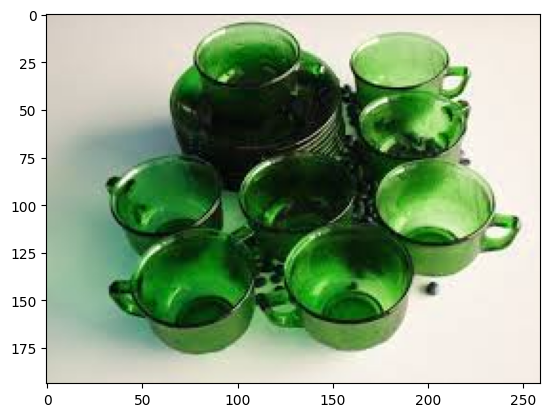

In [89]:
label = img_path_list[5].split('/')[-1]
print(label)
img = cv.imread(img_path_list[5] + "/" + img_list[5][200])
plt.imshow(img)

### 02. mk def

In [2]:
def load_lmg(img_path_list, img_list):
    train_img = list()
    test_img = list()

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(int(len(img_list[path_num]) * 0.8) + 1, len(img_list[path_num])): ### split 0.2 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            test = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            test = cv.resize(test, (64, 64))
            test = cv.cvtColor(test, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            test_img.append([np.array(test) / 255.0, np.array(label)])

    
    return train_img, test_img

In [3]:
cur_dir = os.getcwd()
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 

In [4]:
img_path_list = list()
img_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

In [5]:
train_img, test_img = load_lmg(img_path_list, img_list)

In [6]:
print(f"=============\nDataset\n=============\ntrain: {len(train_img)}\ntest: {len(test_img)}")

Dataset
train: 12409
test: 3094


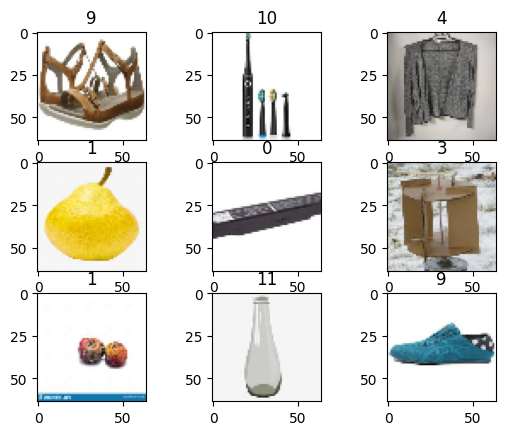

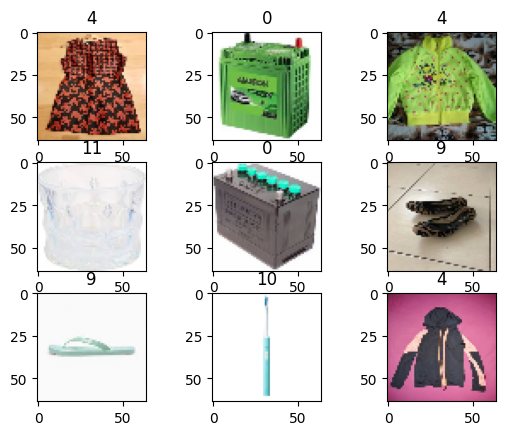

In [7]:
import random
ran_num = random.sample(range(1, 12409), 9)
ran_num_test = random.sample(range(1, 3094), 9)

i = 0
for _ in ran_num:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(train_img[_][0])
    plt.title(train_img[_][1])
plt.show()

i = 0
for _ in ran_num_test:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(test_img[_][0])
    plt.title(test_img[_][1])
plt.show()

> test

## Model - Prototype

In [11]:
train_images = np.array([item[0] for item in train_img])
train_labels = np.array([item[1] for item in train_img])
test_images = np.array([item[0] for item in test_img])
test_labels = np.array([item[1] for item in test_img])

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(12409).batch(128) 

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(1000)

model = Sequential([
    ### layer 1 ###
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 2 ###
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 3 ###
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 4 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 5 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 6 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
  
    Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(12, activation = 'softmax')
])

optimizer = Adam(learning_rate=0.0002)

early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs = 100, validation_data = test_dataset, callbacks=[early_stopping], verbose = 1)

Epoch 1/100
97/97 [==============================] - 49s 484ms/step - loss: 16.8470 - accuracy: 0.4579 - val_loss: 17.0200 - val_accuracy: 0.3439
Epoch 2/100
97/97 [==============================] - 46s 479ms/step - loss: 15.0870 - accuracy: 0.6034 - val_loss: 16.3722 - val_accuracy: 0.3439
Epoch 3/100
97/97 [==============================] - 47s 482ms/step - loss: 13.6021 - accuracy: 0.6453 - val_loss: 15.8059 - val_accuracy: 0.3613
Epoch 4/100
97/97 [==============================] - 47s 481ms/step - loss: 12.2053 - accuracy: 0.6760 - val_loss: 14.8144 - val_accuracy: 0.3442
Epoch 5/100
97/97 [==============================] - 47s 481ms/step - loss: 10.9154 - accuracy: 0.7052 - val_loss: 12.3735 - val_accuracy: 0.3895
Epoch 6/100
97/97 [==============================] - 47s 483ms/step - loss: 9.7501 - accuracy: 0.7261 - val_loss: 10.9222 - val_accuracy: 0.4095
Epoch 7/100
97/97 [==============================] - 76s 784ms/step - loss: 8.7034 - accuracy: 0.7473 - val_loss: 9.6916 - va

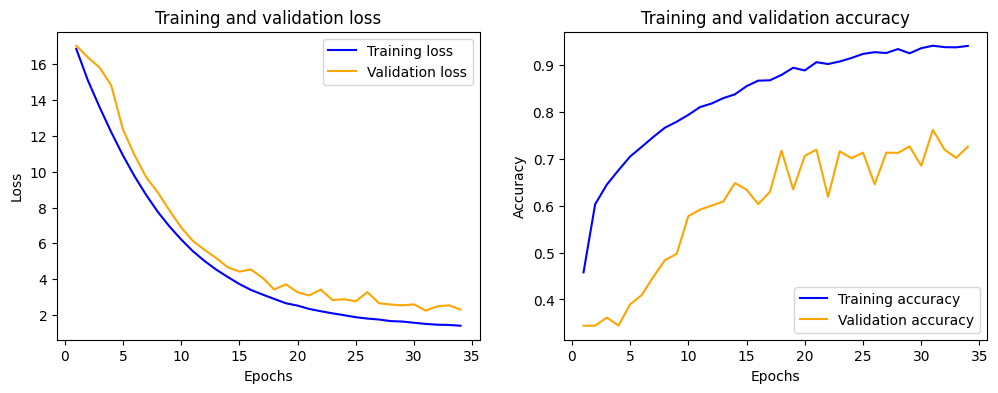

In [12]:
### 시각화 ###

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, color="blue", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, color="blue", label='Training accuracy')
plt.plot(epochs, val_accuracy, color="orange", label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Data Augmentation

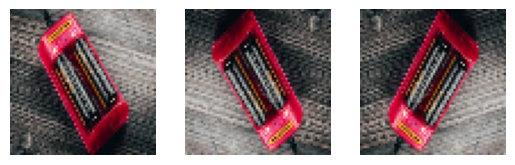

In [23]:
plt.subplot(1, 3, 1)
plt.imshow(train_img[2][0][:,::-1])
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(train_img[2][0][::-1, :])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(train_img[2][0][::-1,::-1])
plt.axis("off")

plt.show()

In [4]:
def load_lmg(img_path_list, img_list):
    train_img = list()
    test_img = list()

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train[:, ::-1]) / 255.0, np.array(label)])

    for path_num in range(len(img_path_list)):
        for img_num in range(0, int(len(img_list[path_num]) * 0.8)): ### split 0.8 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            train = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            train = cv.resize(train, (64, 64))
            train = cv.cvtColor(train, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            train_img.append([np.array(train[::-1,::-1]) / 255.0, np.array(label)])


    for path_num in range(len(img_path_list)):
        for img_num in range(int(len(img_list[path_num]) * 0.8) + 1, len(img_list[path_num])): ### split 0.2 ###
            ### label ###
            label = path_num
            ### img extract and preprocessing ###
            test = cv.imread(img_path_list[path_num] + "/" + img_list[path_num][img_num])
            test = cv.resize(test, (64, 64))
            test = cv.cvtColor(test, cv.COLOR_BGR2RGB)
            ### / 255.0 normalization
            test_img.append([np.array(test) / 255.0, np.array(label)])

    
    return train_img, test_img

In [5]:
cur_dir = os.getcwd()
img_path = "./archive02/garbage_classification/"
label_list = os.listdir(img_path) 
    

img_path_list = list()
img_list = list()

for _ in label_list:
    img_path_list.append(img_path + _)

for _ in label_list:
    img_list.append(os.listdir(img_path + _))

In [6]:
### 함수 실행 코드 ###
train_img, test_img = load_lmg(img_path_list, img_list)

In [7]:
print(f"=============\nDataset\n=============\ntrain: {len(train_img)}\ntest: {len(test_img)}")

Dataset
train: 37227
test: 3094


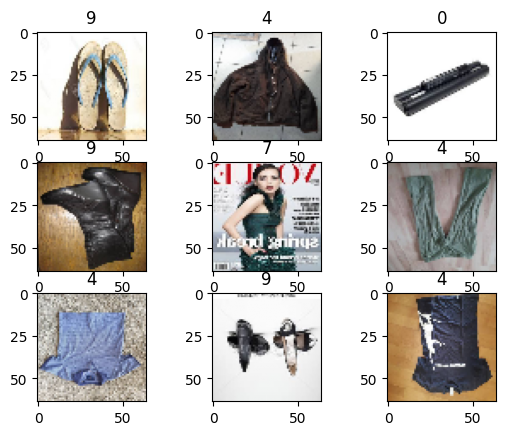

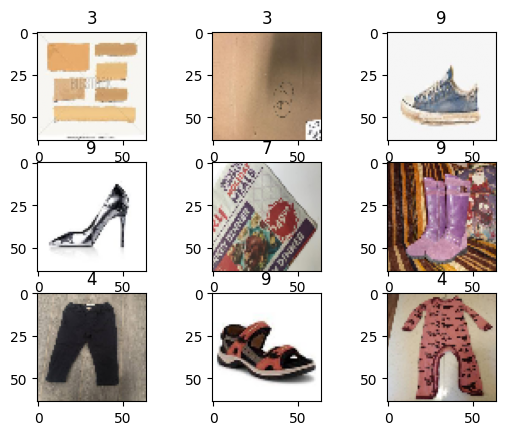

In [10]:
import random
ran_num = random.sample(range(1, 37227), 9)
ran_num_test = random.sample(range(1, 3094), 9)

i = 0
for _ in ran_num:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(train_img[_][0])
    plt.title(train_img[_][1])
plt.show()

i = 0
for _ in ran_num_test:
    i += 1
    plt.subplot(3, 3, i)
    plt.imshow(test_img[_][0])
    plt.title(test_img[_][1])
plt.show()

In [11]:
train_images = np.array([item[0] for item in train_img])
train_labels = np.array([item[1] for item in train_img])
test_images = np.array([item[0] for item in test_img])
test_labels = np.array([item[1] for item in test_img])

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(37227).batch(128) 

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(1000)

model = Sequential([
    ### layer 1 ###
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.2),
    ### layer 2 ###
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    ### layer 3 ###
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.4),
    ### layer 4 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.4),
    ### layer 5 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.4),
    ### layer 6 ###
    Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
  
    Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(12, activation = 'softmax')
])

optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

history = model.fit(train_dataset, epochs = 100, validation_data = test_dataset, callbacks=[early_stopping], verbose = 1)



Epoch 1/100


291/291 [==============================] - 159s 538ms/step - loss: 15.7042 - accuracy: 0.4655 - val_loss: 16.7599 - val_accuracy: 0.3591
Epoch 2/100
291/291 [==============================] - 154s 529ms/step - loss: 11.6768 - accuracy: 0.5983 - val_loss: 11.7832 - val_accuracy: 0.3733
Epoch 3/100
291/291 [==============================] - 153s 527ms/step - loss: 8.5607 - accuracy: 0.6508 - val_loss: 8.1454 - val_accuracy: 0.4867
Epoch 4/100
291/291 [==============================] - 151s 520ms/step - loss: 6.2674 - accuracy: 0.6941 - val_loss: 6.0978 - val_accuracy: 0.5633
Epoch 5/100
291/291 [==============================] - 151s 520ms/step - loss: 4.6624 - accuracy: 0.7269 - val_loss: 4.7510 - val_accuracy: 0.5485
Epoch 6/100
291/291 [==============================] - 152s 523ms/step - loss: 3.5825 - accuracy: 0.7534 - val_loss: 3.7066 - val_accuracy: 0.6496
Epoch 7/100
291/291 [==============================] - 153s 524ms/step - loss: 2.8661 - accuracy: 0.7718 - val

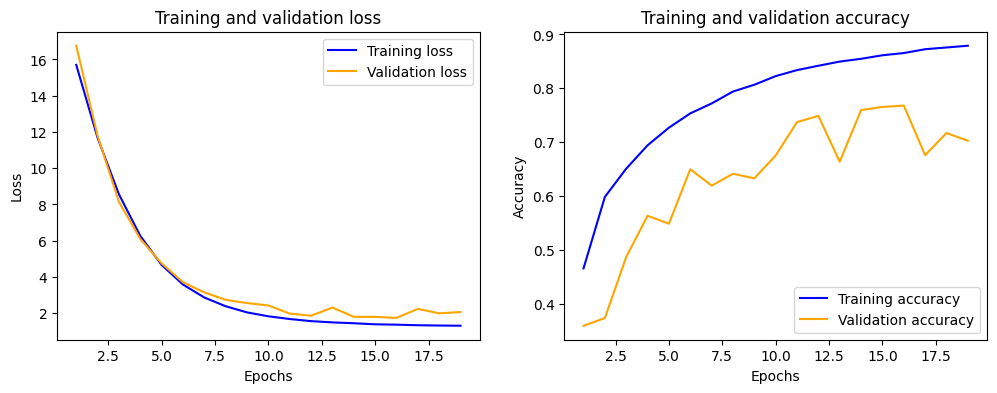

In [13]:
### 시각화 ###

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, color="blue", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, color="blue", label='Training accuracy')
plt.plot(epochs, val_accuracy, color="orange", label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

vgg + adam 모델 튜닝    - 오늘 5시 50분

모델 붙이기             - 내일 오전    ==> 디코딩 구현, //test data 출력//

ppt 자료, 발표 준비 //  - 내일 오전 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.


In [8]:
# CIFAR10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.6580, 0.6161, 0.5856], [0.2715, 0.2830, 0.2974]) # 알려진 CIFAR10의 평균과 표준편차
])

# 데이터셋 불러오기
garbage_dataset = datasets.ImageFolder(root="./archive02/garbage_classification", transform=transform)
# DataLoader를 사용하여 이미지 데이터를 배치 단위로 불러올 수 있음
# garbage_loader = torch.utils.data.DataLoader(garbage_dataset, batch_size=1, shuffle=False)

total_size = len(garbage_dataset)
# 훈련 세트의 비율 설정
train_ratio = 0.8

# 훈련 세트와 테스트 세트로 나누기
train_size = int(train_ratio * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(garbage_dataset, [train_size, test_size])

# 훈련과 테스트 데이터로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [10]:
### basic ###

class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)

    def forward(self, x):
        return self.vggnet(x)

In [9]:
class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.vggnet.features(x)
        x = self.vggnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vggnet.classifier(x)
        x = self.dropout(x)
        return x

In [11]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [12]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# 훈련 함수    
def train(model, train_loader, optimizer, epoch):

    
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)

In [14]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [15]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7797
Test loss: 2.0293, Accuracy: 33.32%


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip

transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

transform_horizontal_flip = transforms.Compose([
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

transform_vertical_flip = transforms.Compose([
    RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

train_dataset_original = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform_original)
train_dataset_horizontal_flip = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform_horizontal_flip)
train_dataset_vertical_flip = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform_vertical_flip)

# 결합
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([train_dataset_original, train_dataset_horizontal_flip, train_dataset_vertical_flip])

# 데이터 로더
combined_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=128, shuffle=True)

* 증강
* L2 규제
* dropout 수치 조정
* batch 사이즈 조정
* max pooling
* 커널, stride 조정
* 